Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('./data/word2vec/text8.zip', 31344016)

Found and verified ./data/word2vec/text8.zip


Read the data into a string.

In [9]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

### `collections`模块方法统计单词频次
---
`count`列表中，存储各个单词与出现频次的`tuple`（第一个是'UNK'（也就是Unkown低频）单词与出现频率）。
`collections.Counter()`返回一个计数器实例，统计words中所有单词的出现频次，调用`most_common(n)`方法会以列表的形式返回计数的前n个结果，每个列表元素是单词与出现频次组成的`tuple`。

In [10]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]

  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # dictionary[word]中对应的value是每个单词的index，一共是出现频次最多的49999个单词
  # 第一个是'UNK',也就是低频词
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  # 这里的index，是在整个数据集words中单词对应的dictionary中的单词序号。如果该单词不
  # 在dictionary中（也就是被排除在前49999之外的低频词），则序号为0（即dictionary['UNK']）
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

50000
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

`collections.deque`创建的队列可以从头部和尾部添加或删除值，且是线程安全的。

In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      # 这里这一步循环，是为了打乱中心词与上下文词的排列顺序，不再按照原来buffer中的顺序排列，而是随机排列
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      # 记录中心词
      batch[i * num_skips + j] = buffer[skip_window]
      # 记录输入数据对应的上下文词
      labels[i * num_skips + j, 0] = buffer[target]
    # 这里如果一个batch_size超过num_skips时，每循环一次，中心词会向后移动一个。由于
    # buffer的maxlen=span且已经存储满，这里append将会挤掉第一个词，从而形成新中心词
    # 的Window，也就是说，batch和labels将会存储 batch_size // num_skips 个中心词与其
    # 上下文词的组合
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'a', 'anarchism', 'as', 'of', 'term', 'originated']


Train a skip-gram model.

In [15]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

# random.sample(population, k)表示从population中随机选取k个元素输出
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  # 做逻辑分类时的权重
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  # 做逻辑分类时的偏差
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # 在embeddings中找与train_dataset对应的向量，并返回由这些向量构成的tensor
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # 这里使用的tf.nn.sampled_softmax_loss采用了负采样的方法，负采样词个数num_sampled = 64
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  # 计算词向量的相似性，用余弦距离衡量
  # 求向量的模norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  # 标准化向量，用原向量embeddings除以模norm得到标准化后的单位向量normalized_embeddings
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  # 根据余弦相似定理，计算相似性
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [16]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      # eval()函数将字符串当成有效的表达式求值并返回结果
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # argsort()函数会对nparray对象按照从小到大排序，并返回排序后元素对应的原ndarray对象中的index
        # 例如 
        # x = np.array([3, 1, 2])
        # x.argsort()
        # >>> [1, 2, 0] # ndarray排序后对应原来的index位置
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.724270
Nearest to of: balkh, funny, porta, medians, karelian, quartic, distrust, correspondent,
Nearest to its: dudley, acres, emerging, bush, lesbians, catwoman, tumor, infighting,
Nearest to more: classrooms, bloemfontein, moorcock, irreplaceable, patchy, chimpanzees, changing, belonged,
Nearest to during: unspecified, blanche, prefix, grace, dermot, peerless, mutilated, everyone,
Nearest to used: cereal, narn, thessalonians, convergent, nickname, risky, superboy, cw,
Nearest to is: monism, amino, oaxaca, henceforth, suits, calvert, sink, dormant,
Nearest to into: yunnan, overseer, slings, salamander, enix, rawls, incandescent, avalon,
Nearest to which: ethology, akbar, concessions, massacres, peroxides, exogenous, gleason, congressmen,
Nearest to zero: tsr, diffusion, leaning, spoofing, arsenic, transit, taker, muzzle,
Nearest to most: valera, novo, detainee, evangelist, globe, susie, habilis, hsu,
Nearest to american: som, presheaf, hb, flakes,

Average loss at step 52000: 3.438593
Average loss at step 54000: 3.431970
Average loss at step 56000: 3.435256
Average loss at step 58000: 3.400389
Average loss at step 60000: 3.393924
Nearest to of: in, for, including, sumner, same, dairy, pivots, barre,
Nearest to its: their, his, the, her, millennial, your, scrupulous, willem,
Nearest to more: less, most, very, longer, larger, visualizing, smaller, rather,
Nearest to during: after, before, since, in, when, until, at, although,
Nearest to used: known, referred, described, found, considered, available, seen, called,
Nearest to is: was, are, has, does, contains, be, omissions, makes,
Nearest to into: within, through, from, rawls, over, around, ub, pim,
Nearest to which: that, this, what, however, who, it, these, there,
Nearest to zero: five, four, seven, eight, six, nine, three, two,
Nearest to most: more, some, many, less, seleucid, communal, all, skin,
Nearest to american: british, classifies, english, dutch, biochemists, african, in

In [19]:
num_points = 800

# 如果向量空间维数过高，建议先使用PCA降维降至50维左右，再使用t-SNE降至二维或三维，因为
# 直接使用t-SNE给高位向量空间做降维，效率比较低
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

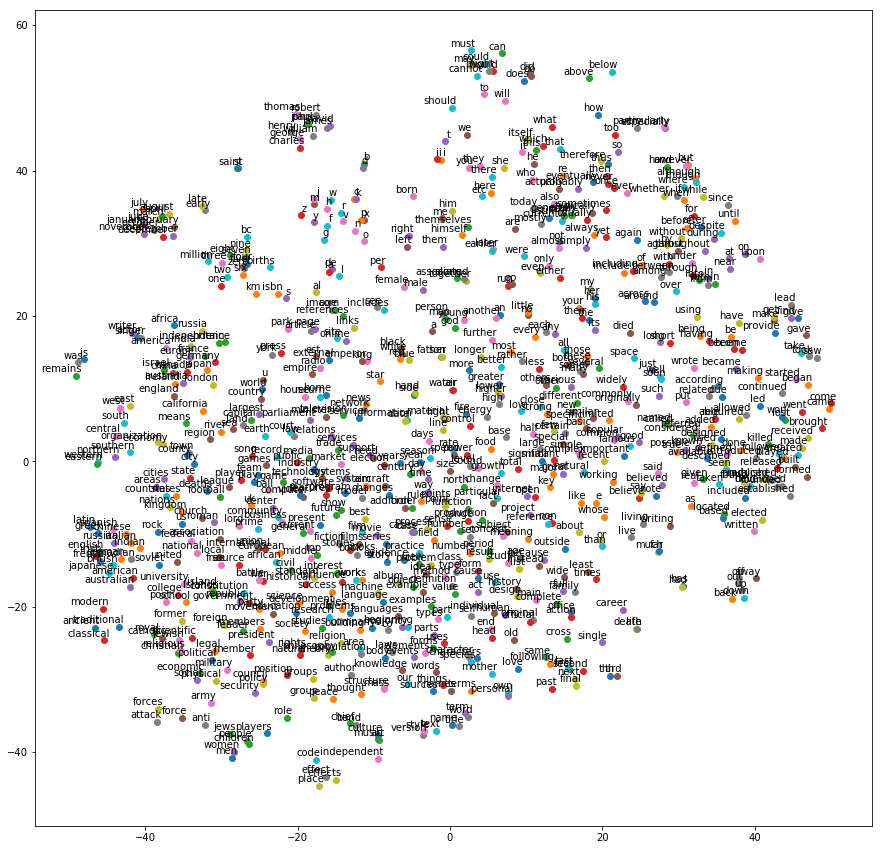

In [18]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### 创建CBOW模型
---
CBOW模型除了输入与输出相对于Skip-Gram是颠倒状态以外，还有一个比较特别的地方，在模型上，CBOW模型的输入层位sum函数，结果为输入矢量的加权平均值。以`[[3,600], [90, 58], [600,77],[58,888],[77,965]]`为输入，`[90, 600, 58, 77, 88]`为输出。

In [25]:
data_index = 0

def generate_batch_CBOW(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # 这里的batch要设置为一个2d的array，每一行代表一个词对应的环境
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
  
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    # 定义一个temp的batch array作为暂时存储环境的array，存储完毕后输出
    batch_temp = np.ndarray(shape=(num_skips), dtype=np.int32)
    
    for j in range(num_skips):
      # 这里这一步循环，是为了打乱中心词与上下文词的排列顺序，不再按照原来buffer中的顺序排列，而是随机排列
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch_temp[j] = buffer[target]

    batch[i] = batch_temp
    labels[i, 0] = buffer[skip_window]
    # 这里如果一个batch_size超过num_skips时，每循环一次，中心词会向后移动一个。由于
    # buffer的maxlen=span且已经存储满，这里append将会挤掉第一个词，从而形成新中心词
    # 的Window，也就是说，batch和labels将会存储 batch_size // num_skips 个中心词与其
    # 上下文词的组合
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

# print('data:', [reverse_dictionary[di] for di in data[:8]])

# for num_skips, skip_window in [(2, 1), (4, 2)]:
#     data_index = 0
#     batch, labels = generate_batch_CBOW(batch_size=8, num_skips=num_skips, skip_window=skip_window)
#     print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
#     print('    batch:', [reverse_dictionary[bi] for bi in batch])
#     print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

In [28]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

# random.sample(population, k)表示从population中随机选取k个元素输出
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  # 这里由于我们的输入对于每个词而言有一个context的输入，我们的input的大小为batch_size X context
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, skip_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  # 做逻辑分类时的权重
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  # 做逻辑分类时的偏差
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # 在embeddings中找与train_dataset对应的向量，并返回由这些向量构成的tensor
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # 加权平均embed向量
  reduced_embed = tf.div(tf.reduce_sum(embed, 1), skip_window*2)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # 这里使用的tf.nn.sampled_softmax_loss采用了负采样的方法，负采样词个数num_sampled = 64
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=reduced_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  # 计算词向量的相似性，用余弦距离衡量
  # 求向量的模norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  # 标准化向量，用原向量embeddings除以模norm得到标准化后的单位向量normalized_embeddings
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  # 根据余弦相似定理，计算相似性
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [29]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_CBOW(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      # eval()函数将字符串当成有效的表达式求值并返回结果
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # argsort()函数会对nparray对象按照从小到大排序，并返回排序后元素对应的原ndarray对象中的index
        # 例如 
        # x = np.array([3, 1, 2])
        # x.argsort()
        # >>> [1, 2, 0] # ndarray排序后对应原来的index位置
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.539443
Nearest to such: ripley, commonwealth, stomachs, away, burials, blaze, propagating, pharmacological,
Nearest to after: operate, curling, reciprocal, contained, medallist, disconnect, pca, lascaris,
Nearest to first: fiddler, rubric, risky, oireachtas, vitae, blanks, vegas, novo,
Nearest to world: climbers, versatile, gassing, assimilated, robert, brazzaville, japanese, reducible,
Nearest to often: firstly, outpost, rotterdam, perot, alley, deutsch, chao, michele,
Nearest to system: moved, tocharians, antiderivative, rectum, kindred, iraqi, sadr, generis,
Nearest to s: ataxia, pisa, clg, princess, prepares, tter, stupid, ssr,
Nearest to this: ius, degradation, resistivity, tecumseh, prut, helena, unwieldy, pilgrimage,
Nearest to see: nutshell, foodstuffs, moldovan, vantaa, ethnological, annexing, commanders, vocalized,
Nearest to on: voss, alkaloids, yugoslav, beni, bauds, append, recession, termed,
Nearest to called: heuvelmans, breath, edge

Average loss at step 52000: 2.885128
Average loss at step 54000: 2.861164
Average loss at step 56000: 2.856404
Average loss at step 58000: 2.766829
Average loss at step 60000: 2.826768
Nearest to such: these, certain, well, including, many, disrupted, known, possible,
Nearest to after: before, during, when, despite, without, following, through, until,
Nearest to first: last, second, third, next, fourth, final, monsoon, nanosystems,
Nearest to world: inexperience, gassing, unhelpful, steffi, greeks, difficulty, assimilated, discordianism,
Nearest to often: usually, sometimes, generally, typically, commonly, now, frequently, still,
Nearest to system: systems, neuropsychological, scenes, interpretation, bile, network, mika, choked,
Nearest to s: vladimir, netted, isbn, filesystem, splintered, his, pressurised, cul,
Nearest to this: which, it, what, the, another, flush, garnering, roden,
Nearest to see: include, kathmandu, brevity, tends, called, vaccination, securities, pj,
Nearest to on:

In [30]:
num_points = 800

# 如果向量空间维数过高，建议先使用PCA降维降至50维左右，再使用t-SNE降至二维或三维，因为
# 直接使用t-SNE给高位向量空间做香味，效率比较低
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

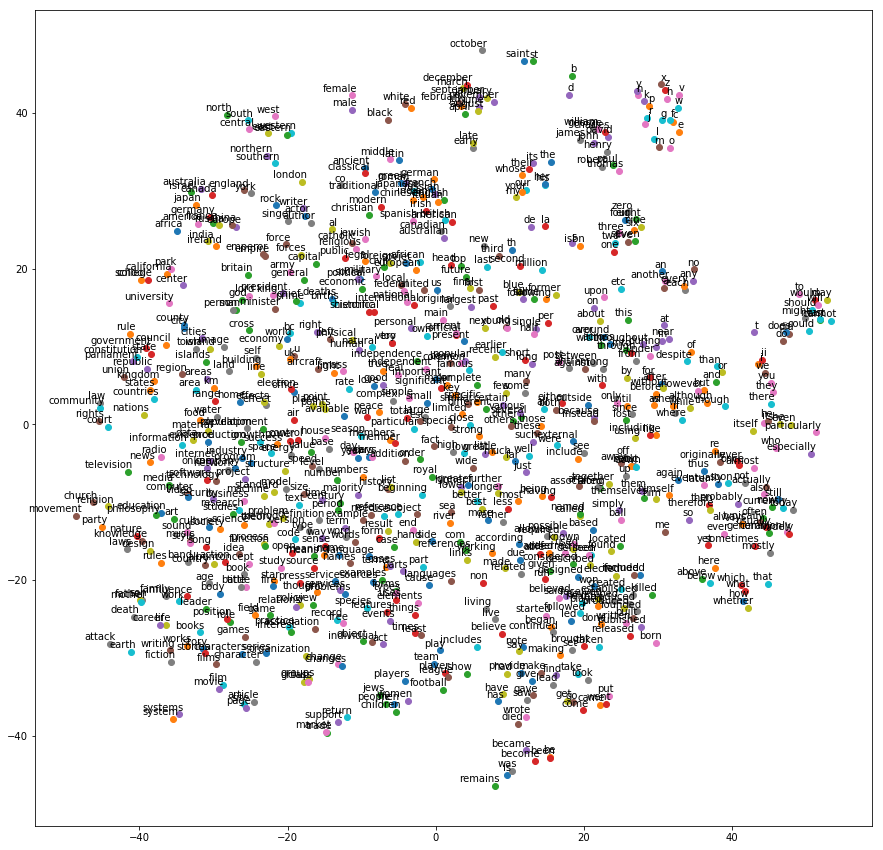

In [31]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)